Lambda School Data Science

*Unit 2, Sprint 3, Module 3*

---


# Applied Modeling, Module 3

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] Continue to iterate on your project: data cleaning, exploration, feature engineering, modeling.
- [ ] Make at least 1 partial dependence plot to explain your model.
- [ ] Share at least 1 visualization on Slack.

(If you have not yet completed an initial model yet for your portfolio project, then do today's assignment using your Tanzania Waterpumps model.)

## Stretch Goals
- [ ] Make multiple PDPs with 1 feature in isolation.
- [ ] Make multiple PDPs with 2 features in interaction. 
- [ ] Use Plotly to make a 3D PDP.
- [ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox. Get readable category names on your plot, instead of integer category codes.

## Links
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pdpbox

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
# Initialize dataset

import pandas as pd
df0 = pd.read_csv('https://socratesdidnothingwrong.com/nfl/qbcf/master.txt')

In [0]:
def engineer(df, fn):
  return df.apply(fn, axis=1)

def netyardsatt(att, passyards, sacks, sackyards):
  return (passyards - sackyards) / (att + sacks)

def rushingefficiency(att, yds):
  return 0 if att == 0 else yds / att

def tdtodiff(passtds, rushtds, ints, fums):
  return passtds + rushtds - ints - fums

def wrangle(df):
  df = df.copy()

  # remove "QBs" with no passes
  df = df[df['passatt'] > 0]

  # some qbs have a trailing '*' on their name
  df['player'] = df['player'].str.replace(r'\*$', '')

  # fix missing `sacks`/`sackyards` data
  df['sacks'] = df['sacks'].fillna(0)
  df['sackyards'] = df['sackyards'].fillna(0)

  # severely imbalanced classes;
  # remove everyone who doesn't have a full season of data
  vc = df['player'].value_counts()
  df = df[df['player'].isin(vc[vc >= 16].index.to_list())]

  # turn `date` into a date
  df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)

  # engineer a `season`-year feature
  df['season'] = df['date'].apply(lambda x: x.year if x.month > 6 else x.year - 1)

  # engineer a `postseason` flag
  df['postseason'] = (df['week'] > 17).astype(int)

  # engineer passing stats
  df['cmp%'] = engineer(df, lambda x: x['completions'] / x['passatt'])
  df['ny/a'] = engineer(df, lambda x: netyardsatt(x['passatt'],
                                                  x['passyards'],
                                                  x['sacks'],
                                                  x['sackyards']))

  # determine rushing efficiency
  df['ypc'] = engineer(df, lambda x: rushingefficiency(x['rushatt'],
                                                           x['rushyards']))
  
  # calculate Touchdown : Turnover differential
  df['td:to'] = engineer(df, lambda x: tdtodiff(x['passtds'],
                                                x['rushtds'],
                                                x['ints'],
                                                x['fumbles']))
  
  keepem = ['player', 'season', 'week', 'game', 'postseason', 'home',
            'cmp%', 'passatt', 'ny/a', 'rushatt', 'ypc', 'td:to']
  df = df[keepem]
  df = df.rename(columns={'passatt': 'attempts', 'rushatt': 'carries'})

  return df

df_w = wrangle(df0)
print(df_w.shape)
print(df_w['player'].nunique())
df_w.head()

(8723, 12)
136


,player,season,week,game,postseason,home,cmp%,attempts,ny/a,carries,ypc,td:to
0,Geno Smith,2013,13,12,0,1,0.400000,10,1.909091,1,2.000000,-1
1,Ryan Tannehill,2013,13,12,0,0,0.651163,43,7.454545,3,7.333333,1
2,Brandon Weeden,2013,13,12,0,1,0.600000,40,7.953488,2,2.500000,-1
3,Joe Flacco,2013,13,12,0,1,0.685714,35,6.405405,4,1.750000,0
4,Matt Flynn,2013,13,12,0,0,0.500000,20,3.777778,2,2.000000,-3


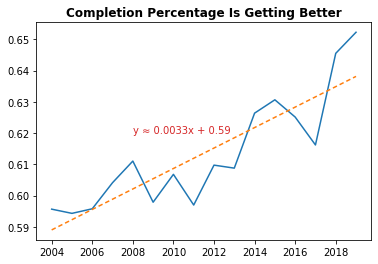

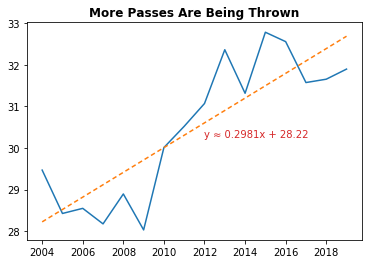

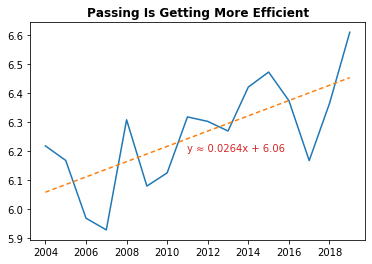

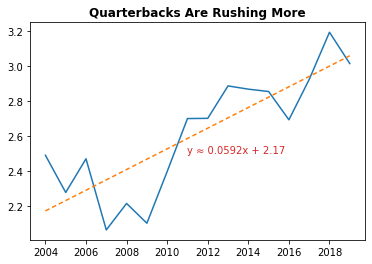

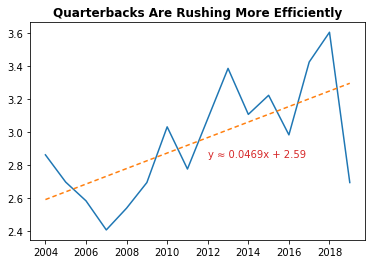

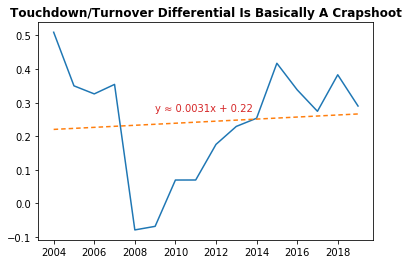

In [0]:
import matplotlib.pyplot as plt
import numpy as np

def changeoveryear(col, name, lblx, lbly):
  xlbls = sorted(df_w['season'].unique())
  xs = list(range(len(xlbls)))
  ys1 = []
  ys2 = []
  for yr in xlbls:
    df1 = df_w[(df_w['season'] == yr) & (df_w['postseason'] == 0)]
    df2 = df1[df1['postseason'] == 1]
    ys1.append(df1[col].mean())
    #ys2.append(df2[col].mean())
  bestfit = np.polyfit(xs, ys1, 1)
  plt.title(name, fontweight='bold')
  plt.plot(xs, ys1)
  #plt.plot(xs, ys2, color='C2')
  plt.plot(xs, np.poly1d(bestfit)(xs), dashes=(3,2))
  plt.xticks(xs[::2], xlbls[::2])
  sign = '-' if bestfit[1] < 0 else '+'
  plt.text(lblx, lbly,
           f'y ≈ {bestfit[0]:.4f}x {sign} {np.absolute(bestfit[1]):.2f}',
           color='C3')
  plt.show()
  print()

changeoveryear('cmp%', 'Completion Percentage Is Getting Better', 4, 0.62)
changeoveryear('attempts', 'More Passes Are Being Thrown', 8, 30.25)
changeoveryear('ny/a', 'Passing Is Getting More Efficient', 7, 6.2)
changeoveryear('carries', 'Quarterbacks Are Rushing More', 7, 2.5)
changeoveryear('ypc', 'Quarterbacks Are Rushing More Efficiently', 8, 2.85)
changeoveryear('td:to', 'Touchdown/Turnover Differential Is Basically A Crapshoot', 5, 0.275)

Based on the above graphs, I conclude that I must adjust these stats by season; use z-scores instead of raw data

In [0]:
stats = ['cmp%', 'attempts', 'ny/a', 'carries', 'ypc', 'td:to']
years = range(2004, 2019+1)
df_norm = df_w.copy()
for y in years:
  df = df_w[df_w['season'] == y]
  for s in stats:
    m = df[s].mean()
    sd = df[s].std()
    df_norm.loc[df_norm['season'] == y, s] = (df_w[s] - m) / sd
df_norm = df_norm.drop(columns='week')
df_norm.head()

,player,season,game,postseason,home,cmp%,attempts,ny/a,carries,ypc,td:to
0,Geno Smith,2013,12,0,1,-1.731589,-1.929814,-1.996211,-0.745945,-0.333316,-0.660409
1,Ryan Tannehill,2013,12,0,0,0.355435,0.921932,0.537252,0.029335,0.932606,0.417611
2,Brandon Weeden,2013,12,0,1,-0.069699,0.662682,0.765196,-0.358305,-0.214636,-0.660409
3,Joe Flacco,2013,12,0,1,0.642539,0.230600,0.057949,0.416975,-0.392656,-0.121399
4,Matt Flynn,2013,12,0,0,-0.900644,-1.065648,-1.142494,-0.358305,-0.333316,-1.738429


In [0]:
df.to_csv('qbcf.txt', index=False)

In [0]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df_norm, test_size=0.2, random_state=143,
                                     stratify=df_norm['player'])

y_col = 'player'
X_cols = df_train.columns.drop(y_col)

X_train = df_train[X_cols]
X_test = df_test[X_cols]
y_train = df_train[y_col]
y_test = df_test[y_col]

In [0]:
!pip install gudhi

ERROR: Could not find a version that satisfies the requirement gudhi (from versions: none)
ERROR: No matching distribution found for gudhi
